<a href="https://colab.research.google.com/github/markgicharu/Fish-Classification-Segmentation/blob/dev-branch/anyoso_Fish_classification_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Defining the question. 

### a) Specifying the data analytic question 

The goal of this project is to classify images of fish as per their respective species names. 

### b) Defining the metrics of success

1. Build a model to correctly classify the images with an accuracy of at least 70% 
2. Evaluate the performance of the model using other performance metrics for the classification such as recall, precision and f1 score. 


In [ ]:
#load libraries

# for data mainipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL
import pickle
import random
from math import sqrt, floor
from prettytable import PrettyTable

# to interact with the operating system
import os
import shutil
import pathlib

# sklearn
from sklearn.utils import class_weight
from sklearn.metrics import classification_report



# for computer vision
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
#from keras.optimizers import SGD
from keras import metrics
from tensorflow.keras.callbacks import TensorBoard
import datetime
import time


Download the Image data set

In [ ]:
#shutil.rmtree(spath)

In [ ]:
# download the images

dataset_url = "https://storage.googleapis.com/fish-classification/fish.tar.gz"
data_dir = keras.utils.get_file('fish', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

461897728/461888131 [==============================] - 5s 0us/step


In [ ]:
spath = "/root/.keras/datasets/"

full_set = "/root/.keras/datasets/fish"
training_set = "/root/.keras/datasets/training"
validation_set = "/root/.keras/datasets/validation"



In [ ]:
# mask images

mask_set = "/root/.keras/datasets/masks"
masks_url = "https://storage.googleapis.com/fish-classification/masks.tar.gz"
masks_dir = keras.utils.get_file('masks', origin=masks_url, untar=True)
masks_dir = pathlib.Path(masks_dir)

mask_count = len(list(masks_dir.glob('*/*')))
print(mask_count)

5931008/5915266 [==============================] - 0s 0us/step
27370


Check if the total number of images is the same; should be 27370

In [ ]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

27370


Copy from full dataset to the training dataset

In [ ]:
# copy tree directory to preserve original dataset 
shutil.copytree(data_dir, '/root/.keras/datasets/training/')


'/root/.keras/datasets/training/'

Visualize the sample size distribution across the entire dataset to check if the samples are evenly distributed

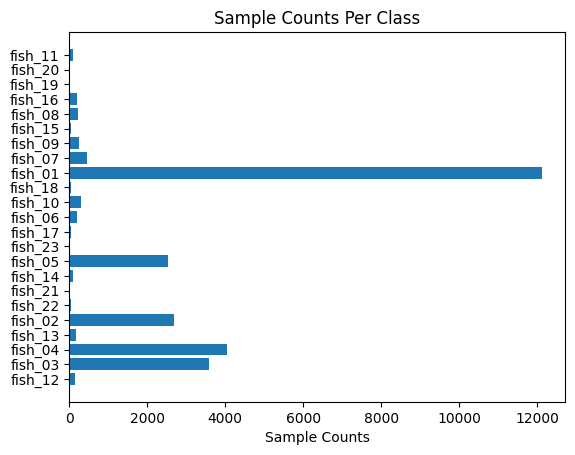

In [ ]:
classes= []
sample_counts= []

for f in os.listdir(full_set):
    train_class_path= os.path.join(full_set, f)
    if os.path.isdir(train_class_path):
        classes.append(f)
        sample_counts.append(len(os.listdir(train_class_path)))

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(len(classes))

ax.barh(y_pos, sample_counts, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(classes)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Sample Counts')
ax.set_title('Sample Counts Per Class')

plt.show()

Visualize Random images from each of the classes

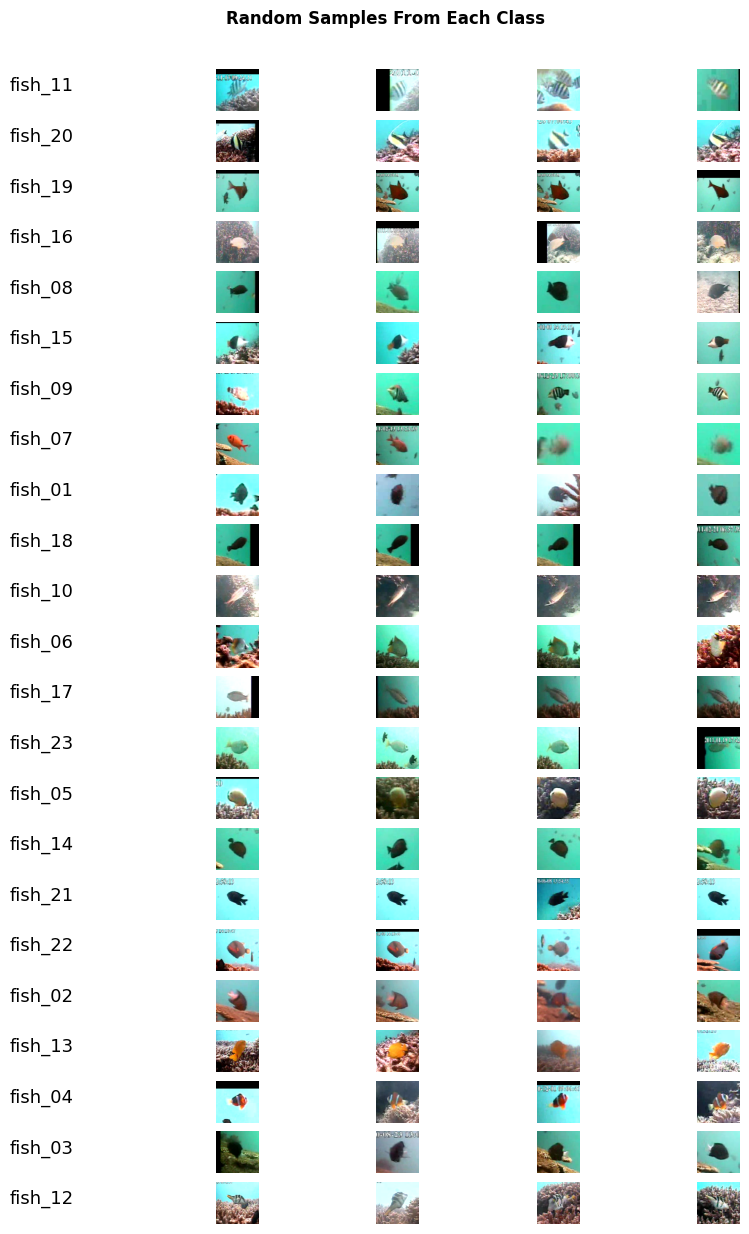

In [ ]:
fig= plt.figure(figsize= (10, 15))
fig.suptitle('Random Samples From Each Class', fontsize=12, y=.92, horizontalalignment='center', weight='bold')

columns = 5
rows = 23
for i in range(23):
    sample_class= os.path.join(full_set,classes[i])
    for j in range(1,6):
        fig.add_subplot(rows, columns, i*5+j)
        plt.axis('off')
        if j==1:
            plt.text(0.0, 0.5,str(classes[i]).replace(' ','\n'), fontsize=13, wrap=True)
            continue
        random_image= os.path.join(sample_class, random.choice(os.listdir(sample_class)))
        #from keras.preprocessing.image
        img = image.load_img(random_image, target_size=(150, 150))
        img= image.img_to_array(img)
        img/=255.
        plt.imshow(img)

plt.show()

 Create validation dataset from 10% of the training dataset

In [ ]:
def create_validation(validation_split=0.1):
    if os.path.isdir(validation_set):
        print('Validation directory already created!')
        print('Process Terminated')
        return
    os.mkdir(validation_set)
    for f in os.listdir(training_set):
        train_class_path= os.path.join(training_set, f)
        if os.path.isdir(train_class_path):
            validation_class_path= os.path.join(validation_set, f)
            os.mkdir(validation_class_path)
            files_to_move= int(0.1*len(os.listdir(train_class_path)))
            
            for i in range(files_to_move):
                random_image= os.path.join(train_class_path, random.choice(os.listdir(train_class_path)))
                shutil.move(random_image, validation_class_path)
    print('Validation set created successfully using {:.2%} of training data'.format(validation_split))
create_validation()

Validation set created successfully using 10.00% of training data


Check the sample size distribution after the split

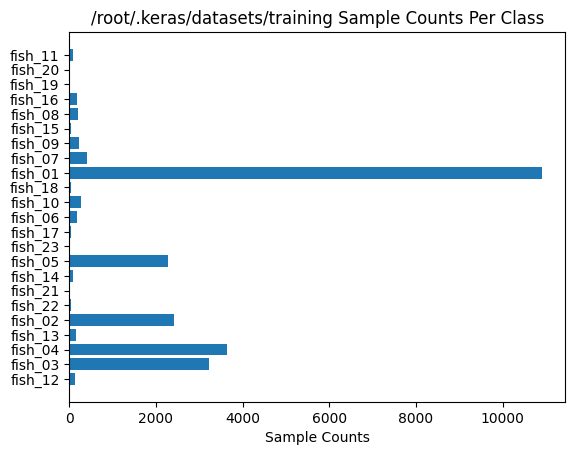

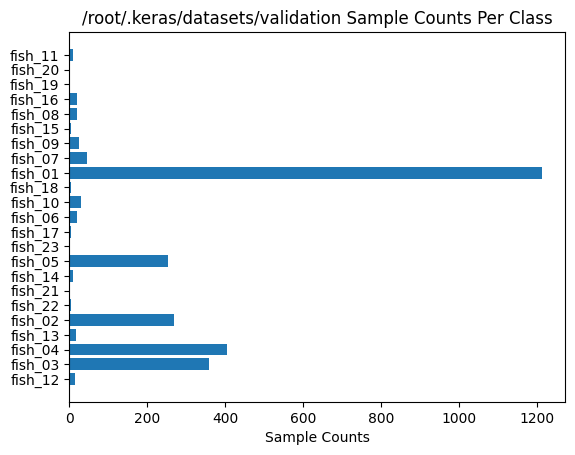

In [ ]:
sample_counts= {}

for i, d in enumerate([training_set, validation_set]):

    classes= []
    sample_counts[d]= []

    for f in os.listdir(d):
        train_class_path= os.path.join(d, f)
        if os.path.isdir(train_class_path):
            classes.append(f)
            sample_counts[d].append(len(os.listdir(train_class_path)))

    fig, ax = plt.subplots()

    # Example data
    y_pos = np.arange(len(classes))

    ax.barh(y_pos, sample_counts[d], align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(classes)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Sample Counts')
    ax.set_title('{} Sample Counts Per Class'.format(d.capitalize()))

plt.show()

Both the training set and the validation set are highly imbalanced.

Visualize the directory structure

In [ ]:
def print_bold(text):
    print('\033[1m{}\033[0m'.format(text))

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        
        dir_name= '{}{}/'.format(indent, os.path.basename(root))
        if dir_name.strip().startswith('.'):
            continue
        
        print_bold('\n'+dir_name)
            
        subindent = ' ' * 4 * (level + 1)
        if level==0:
            for f in files:
                if f.startswith('.'):
                    continue
                print('{}{}'.format(subindent, f))
        else:
            for i, f in enumerate(files):
                print('{}{}'.format(subindent, f))
                if i==2:
                    print('{}{}'.format(subindent, '...'))
                    break

list_files(spath)


/
    masks.tar.gz
    fish.tar.gz

validation/

    fish_11/
        fish_003428105288_25936.png
        fish_003427825288_17825.png
        fish_000011519592_03435.png
        ...

    fish_20/
        fish_004531577348_27172.png
        fish_000024219597_05209.png

    fish_19/
        fish_003470035337_13984.png
        fish_003470175337_23531.png

    fish_16/
        fish_000011679594_03540.png
        fish_000010519594_03472.png
        fish_000014979594_03589.png
        ...

    fish_08/
        fish_000027230001_02847.png
        fish_000008919597_05120.png
        fish_003462545325_13074.png
        ...

    fish_15/
        fish_003486035363_11370.png
        fish_003921366366_11236.png
        fish_004204226874_21756.png
        ...

    fish_09/
        fish_004094756723_17358.png
        fish_004094756723_09696.png
        fish_003381315211_26600.png
        ...

    fish_07/
        fish_003735255892_12322.png
        fish_000008059596_03976.png
        fish_0000262400

**Setting some variables**

Batch size of 32; so 32 samples to propagate through the network

In [ ]:
# initializing some variables

batch_size = 32
img_height = 180
img_width = 180

**Setup Training and Validation datasets. Use 10% of the data for validation**

In [ ]:
# training set

training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_set,
    labels="inferred",
    label_mode="int",
    seed = 123,
    image_size = (img_height,img_width),
    batch_size  = batch_size
)

Found 24643 files belonging to 23 classes.


In [ ]:
# validation set

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_set,
    labels="inferred",
    label_mode="int",
    seed = 123,
    image_size = (img_height,img_width),
    batch_size  = batch_size
)

Found 2727 files belonging to 23 classes.


In [ ]:
class_names = training_dataset.class_names
print(class_names)

['fish_01', 'fish_02', 'fish_03', 'fish_04', 'fish_05', 'fish_06', 'fish_07', 'fish_08', 'fish_09', 'fish_10', 'fish_11', 'fish_12', 'fish_13', 'fish_14', 'fish_15', 'fish_16', 'fish_17', 'fish_18', 'fish_19', 'fish_20', 'fish_21', 'fish_22', 'fish_23']


**Visualize random images from the classes**

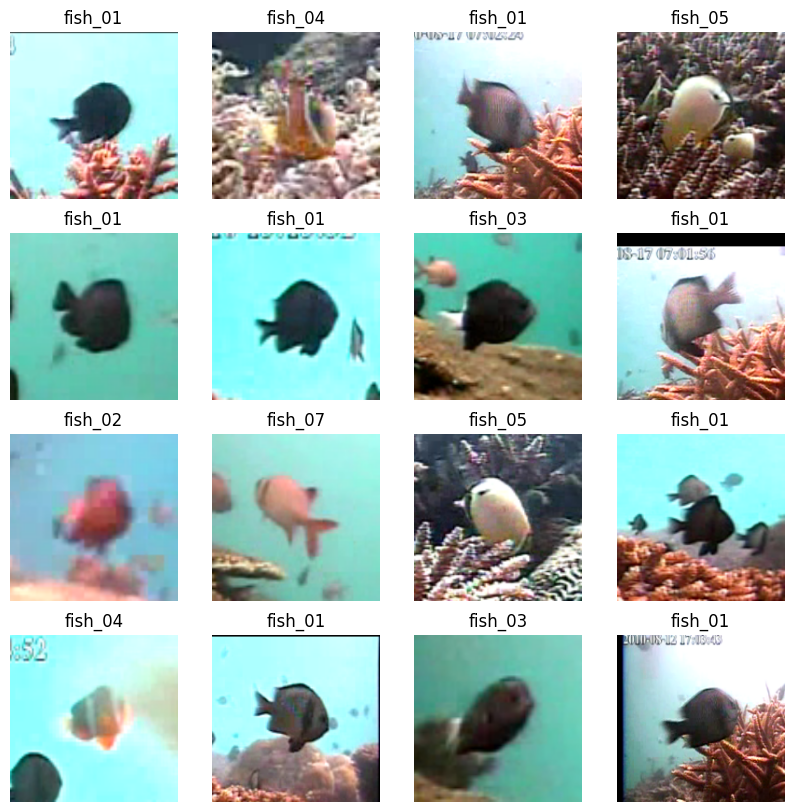

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in training_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in training_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

**Stardardize the data to zero & one from RGB format 0 - 255**

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = training_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

0.0 1.0


**Create the Classification Model, using adam optimizer**

In [ ]:
num_classes = 23

model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
                    layers.Conv2D(16, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(32, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(64, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes),
                    ])

In [ ]:
opt= keras.optimizers.Adam(learning_rate=0.0005,amsgrad=True)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

**Train the model**

Create a callback that saves the model's weights

In [ ]:
checkpoint_loc = "training_checkpoints/cp-ini-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_loc)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,save_weights_only=True,verbose=1)

Initial test, running 10 epochs. No data augmentation applied at this point.

In [ ]:
epochs = 10
history = model.fit(training_dataset,validation_data=validation_dataset,epochs=epochs,callbacks=[cp_callback])

Epoch 1/10
771/771 [==============================] - 66s 47ms/step - loss: 0.3749 - accuracy: 0.8958 - val_loss: 0.1992 - val_accuracy: 0.9421

Epoch 00001: saving model to training_checkpoints
Epoch 2/10
771/771 [==============================] - 31s 40ms/step - loss: 0.1343 - accuracy: 0.9599 - val_loss: 0.1285 - val_accuracy: 0.9604

Epoch 00002: saving model to training_checkpoints
Epoch 3/10
771/771 [==============================] - 30s 39ms/step - loss: 0.0747 - accuracy: 0.9771 - val_loss: 0.1052 - val_accuracy: 0.9696

Epoch 00003: saving model to training_checkpoints
Epoch 4/10
771/771 [==============================] - 30s 39ms/step - loss: 0.0402 - accuracy: 0.9874 - val_loss: 0.0962 - val_accuracy: 0.9721

Epoch 00004: saving model to training_checkpoints
Epoch 5/10
771/771 [==============================] - 31s 40ms/step - loss: 0.0256 - accuracy: 0.9922 - val_loss: 0.1374 - val_accuracy: 0.9652

Epoch 00005: saving model to training_checkpoints
Epoch 6/10
771/771 [=====

In [ ]:
# saving the model

!mkdir -p trained_models
model.save('trained_model/initial_run')

INFO:tensorflow:Assets written to: trained_model/initial_run/assets


**Visualize the result of the training**

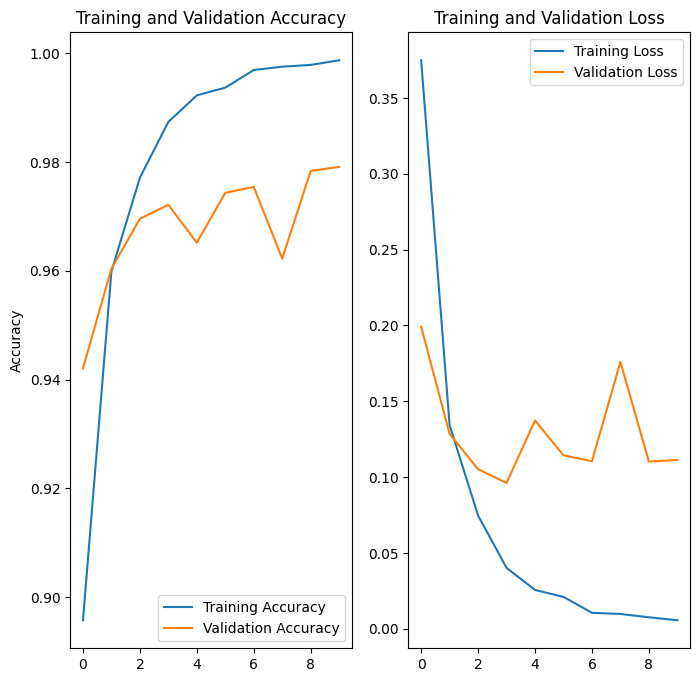

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()
